In [24]:
import argparse
# standard
import os
import pickle
import random
import time
from typing import List

# %matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# from PIL import Image
# imports
# torch and friends
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import os.path as osp
import torchio as tio
import torchvision.utils as vutils
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from torch.utils.data import DataLoader, Dataset
from torchio.transforms.augmentation.intensity.random_bias_field import \
    RandomBiasField
from torchio.transforms.augmentation.intensity.random_noise import RandomNoise
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST, SVHN, FashionMNIST
from torchvision.utils import make_grid
from tqdm import tqdm

import utils.my_trainer as trainer
import utils.train_result as train_result
from datasets.dataset import CLASS_MAP, load_data
# from metrics.fid_score import calculate_fid_given_dataset
from utils.data_load import BrainDataset

from datasets.dataset import load_data#, CLASS_MAP
from sklearn.model_selection import GroupShuffleSplit, StratifiedGroupKFold
import models.models as models

In [25]:
seed_ti = 103

In [26]:
def parser():
    parser = argparse.ArgumentParser(description="example")
    parser.add_argument("--batch_size", type=int, default=8)
    parser.add_argument("--epoch", type=int, default=100)
    parser.add_argument("--lr", type=float, default=0.001)
    parser.add_argument("--log", type=str, default="z-1200")
    parser.add_argument("--n_train", type=float, default=0.8)
    parser.add_argument("--train_or_loadnet", type=str, default="loadnet")    # train or loadnet
    parser.add_argument("--model", type=str, default="CAE")     # VAE or CAE
    #以下を変更でmodelなど変更
    args = parser.parse_args(args=['--model','SoftIntroVAE'])
    return args


# TorchIO
class ImageTransformio():
    def __init__(self):
        self.transform = {
            "train":tio.Compose([
                #tio.RandomBlur(),
                #tio.RandomBiasField(coefficients=1),
                # tio.RandomAffine(scales=(0.9, 1.2), degrees=10, isotropic=True, center="image", default_pad_value="mean", image_interpolation='linear'),
                #tio.ZNormalization(),
                # tio.RescaleIntensity((0, 1))#, in_min_max=(0.1, 255))                
            ]),
            "val":tio.Compose([
                #tio.ZNormalization(),
                # tio.RescaleIntensity((0, 1))#, in_min_max=(0.1, 255))
            ])
        } 
    def __call__(self, img, phase="train"):
        # img_t = torch.unsqueeze(torch.tensor(img), 0) 
        img_t = torch.tensor(img)
        return self.transform[phase](img_t)
        
def load_dataloader(n_train_rate, batch_size):
    data = load_data(kinds=["ADNI2", "ADNI2-2"], classes=["CN", "AD", "EMCI", "LMCI", "SMC", "MCI"], unique=False, blacklist=True)
    pids=[]
    
    voxels = np.zeros((len(data), 80, 96, 80))
    labels = np.zeros(len(data))
    for i in tqdm(range(len(data))):
        pids.append(data[i]["pid"])
        voxels[i] = data[i]["voxel"]
        labels[i] = CLASS_MAP[data[i]["label"]]
    pids = np.array(pids)

#   split index  を指定
    split_index = 4
    sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=seed_ti)
    tid, vid = list(sgk.split(voxels, y=labels, groups=pids))[split_index]
#    tid, vid = list(gss.split(voxels, groups=pids))[0]

    train_voxels = voxels[tid]
    val_voxels = voxels[vid]
    train_labels = labels[tid]
    val_labels = labels[vid]

    train_dataset = BrainDataset(train_voxels, train_labels)
    val_dataset = BrainDataset(val_voxels, val_labels)
    
    g = torch.Generator()
    g.manual_seed(seed_ti)
        
    return train_dataset, val_dataset

In [27]:
args = parser()# args使うときはこれが必要
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() and True else "cpu")
print("device:", device)    

train_set, val_set = load_dataloader(args.n_train, args.batch_size)

device: cuda:0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3898/3898 [00:14<00:00, 275.91it/s]


In [29]:
net = models.SoftIntroVAE(64, [[64,1,2],[128,1,2],[256,2,2]] )
# './logs/z-1200_SoftIntroVAE/8per_rec1_ng512_kl05_annel_ch256/prams/S-IntroVAE_4184_epoch250.pth'
# epoch  819, 820 がいいかもしれん
net.load_state_dict(torch.load('./logs/z-1200_SoftIntroVAE/8per_rec1_ng512_kl05_annel_ch256/prams/S-IntroVAE_4184_epoch819.pth')) 

<All keys matched successfully>

In [30]:
net.to(device);net.eval();print('0')

0


In [31]:
z_train = []
train_labels = []
for i, (train_voxel, train_label) in tqdm(enumerate(train_set)):
    if (train_label == 0) or (train_label == 1):
        input_voxel = torch.tensor(train_voxel.reshape(1,1,80,96,80))
        train_labels.append(train_label)
        with torch.no_grad():
            _, _, z, _ = net.forward(input_voxel.to(device))
            z = z.cpu().detach().numpy()
        z_train.append(z.flatten())
z_train = np.stack(z_train)
train_labels = np.stack(train_labels)

3104it [01:54, 27.13it/s] 


In [32]:
x_train = z_train[(train_labels==0) | (train_labels==1)]
y_train = train_labels[(train_labels==0) | (train_labels==1)]

In [33]:
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

lr = LogisticRegression(penalty="l1", solver="liblinear")
lr.fit(x_train, y_train)
prob = lr.predict_proba(x_train)
fpr, tpr, thresholds = roc_curve(y_train, prob[:,1])
# roc_auc_score(y_train, x_train)

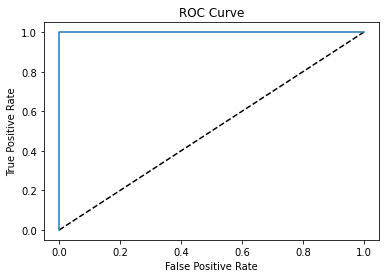

In [34]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [35]:
a=0
store = 0.0

while a < 1:
    z_val = []
    val_labels = []
    for i, (val_voxel, val_label) in tqdm(enumerate(val_set)):
        input_voxel = torch.tensor(val_voxel.reshape(1,1,80,96,80))
        val_labels.append(val_label)
        with torch.no_grad():
            _, _, z, _ = net.forward(input_voxel.to(device))
            z = z.cpu().detach().numpy()
        z_val.append(z.flatten())
    z_val = np.stack(z_val)
    val_labels = np.stack(val_labels)
    
    x_val = z_val[(val_labels==0) | (val_labels==1)]
    y_val = val_labels[(val_labels==0) | (val_labels==1)]
    
    prob = lr.predict_proba(x_val)
    fpr, tpr, thresholds = roc_curve(y_val, prob[:,1])
    print(roc_auc_score(y_val, prob[:,1]))
    store += roc_auc_score(y_val, prob[:,1])
    a += 1

avg = store / 10
print(f"avg == {avg}")

794it [01:00, 13.16it/s]

0.8080107276119404
avg == 0.08080107276119404


In [36]:
x_val = z_val[(val_labels==0) | (val_labels==1)]
y_val = val_labels[(val_labels==0) | (val_labels==1)]

In [37]:
prob = lr.predict_proba(x_val)
fpr, tpr, thresholds = roc_curve(y_val, prob[:,1])
roc_auc_score(y_val, prob[:,1])

0.8080107276119404

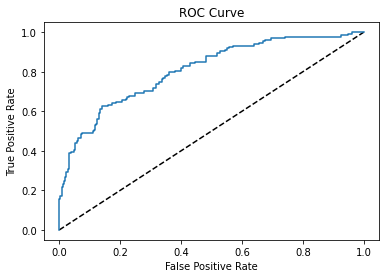

In [38]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.savefig("logistic_Soft.pdf")
plt.show()

In [17]:
z_train.shape

(1405, 1200)

In [18]:
############################################################
############################################################
############################################################
############################################################
############################################################
############################################################
############################################################
############################################################
############################################################

In [34]:
import umap
from scipy.sparse.csgraph import connected_components
from sklearn.decomposition import PCA

pca = PCA(n_components = 50, random_state=42)
umap = umap.UMAP(n_components=2, random_state=42)
pca_x = pca.fit_transform(x_val)
X_reduced_umap = umap.fit_transform(pca_x)

In [91]:
from sklearn.manifold import TSNE
%matplotlib inline
tsne = TSNE(n_components=2, perplexity=20,init = "pca", random_state=0)
X_reduced_tsne = tsne.fit_transform(pca_x)

/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


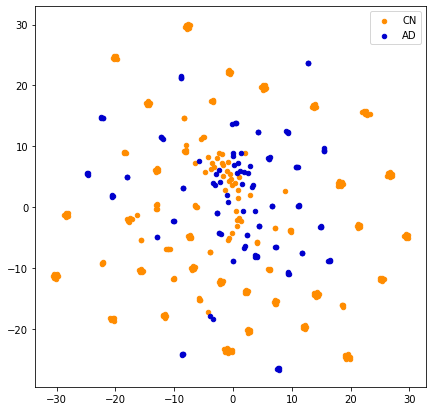

In [55]:
Figure = plt.figure(figsize=(7, 7))
# plt.axis("off")   "royalblue" mediumblue dodgerblue cyan deepskyblue navy cornflowerblue darkorange
plt.scatter(X_reduced_tsne[y_val==0, 0],X_reduced_tsne[y_val==0,1],c="mediumblue", label="CN", s=20)
plt.scatter(X_reduced_tsne[y_val==1, 0],X_reduced_tsne[y_val==1,1],c="darkorange", label="AD", s=20)
plt.legend(loc="best")
plt.show()

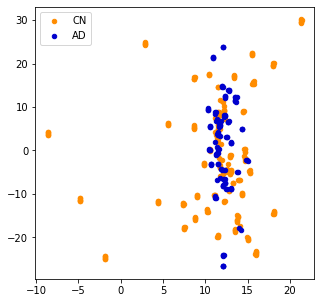

In [56]:
Figure = plt.figure(figsize=(5, 5))
# plt.axis("off")
plt.scatter(X_reduced_umap[y_val==0, 0],X_reduced_tsne[y_val==0,1],c="mediumblue", label="CN", s=20)
plt.scatter(X_reduced_umap[y_val==1, 0],X_reduced_tsne[y_val==1,1],c="darkorange", label="AD", s=20)
plt.legend(loc="best")
plt.savefig("umap.pdf",bbox_inches="tight",pad_inches=0)
plt.show()


In [92]:
import umap
from scipy.sparse.csgraph import connected_components
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

pca = PCA(n_components = 50, random_state=42)
umap = umap.UMAP(n_components=3, random_state=42)
pca_x = pca.fit_transform(x_val)
X_reduced_umap = umap.fit_transform(pca_x)

tsne = TSNE(n_components=3, perplexity=20, init="pca", random_state=0)
X_reduced_tsne = tsne.fit_transform(pca_x)

/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/lucky/.pyenv/versions/3.8.8/envs/brain/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


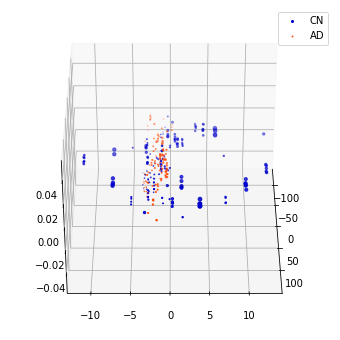

In [134]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=35, azim=0)

# plt.axis("off")
plt.scatter(X_reduced_tsne[y_val==0, 0],X_reduced_umap[y_val==0,1],X_reduced_umap[y_val==0,2],c="mediumblue", label="CN")
plt.scatter(X_reduced_tsne[y_val==1, 0],X_reduced_umap[y_val==1,1],X_reduced_umap[y_val==1,2],c="orangered", label="AD" )
plt.legend(loc="best")
plt.show()

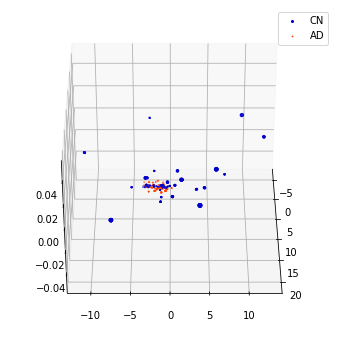

In [135]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=35, azim=0)

# plt.axis("off")
plt.scatter(X_reduced_3D_umap[y_val==0, 0],X_reduced_3D_umap[y_val==0,1],X_reduced_3D_umap[y_val==0,2],c="mediumblue", label="CN")
plt.scatter(X_reduced_3D_umap[y_val==1, 0],X_reduced_3D_umap[y_val==1,1],X_reduced_3D_umap[y_val==1,2],c="orangered", label="AD")
plt.legend(loc="best")
ax.mouse_init()
plt.show()

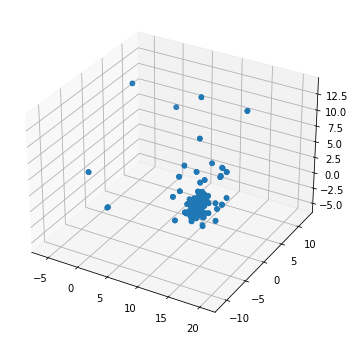

In [95]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1],X_reduced_umap[:, 2])
plt.show()